In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from graphviz import Digraph
import math

In [2]:
def f(x):
    return 3 * x ** 2 - 4 * x + 5

In [3]:
f(3)

20

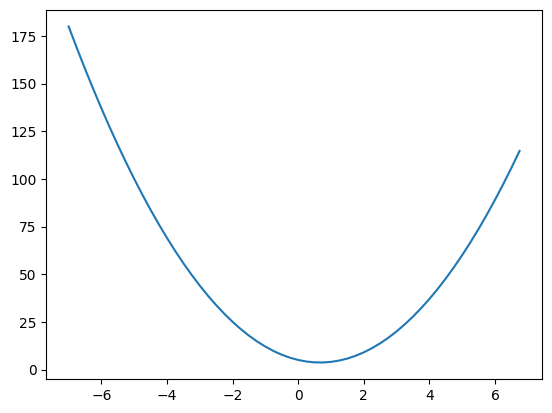

In [4]:
x = np.arange(-7,7,0.25)
y = f(x)
plt.plot(x, y)

In [5]:
h = 0.0001
x = 3
(f(x + h) - f(x)) / h

14.000300000063248

In [5]:
a = 2
b = -3 
c = 10
d = a * b + c
d 

4

In [7]:
h = 0.001
a += h

d1 = a * b + c
slope = (d1 - d) / h
d,d1,slope

(4, 3.997, -3.0000000000001137)

In [62]:
class Value:
    def __init__(self,data,_children=(),_op=(),label='',grad=0):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other.data)
        out = Value(self.data + other.data,(self,other),'+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out
            
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other.data)
        out = Value(self.data * other.data,(self,other),'*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self,other):
        return self * other
    
    def __radd__(self,other):
        return self + other
    
    def __neg__(self):
        return self + (-1)
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __sub__(self,other):
        return self / other
       
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        topological_sort(self)
        
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()    
    
a = Value(2,label='a')
b = Value(-3,label='b')
c = Value(10,label='c')
e = a * b; e.label='e'
d = e + c; d.label='d'
d

Value(data=4)

In [9]:
d._prev

{Value(data=-6), Value(data=10)}

In [10]:
d._op

'+'

In [9]:
# %pip install graphviz
def trace(root):
    # builds a set of all nodes and edges in a graph 
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right 
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        label = getattr(n, 'label', '')  # Use an empty string if 'label' is not found
        # for any value in the graph, create a rectangular ('record') node for it 
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (label, n.data,n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it 
            op_uid = uid + n._op
            dot.node(name=op_uid, label=n._op)
            # and connect this node to it 
            dot.edge(op_uid, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2 
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot


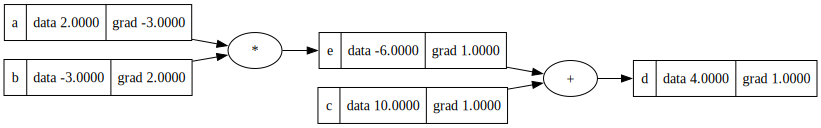

In [38]:
draw_dot(d)

In [10]:
d.grad = 1.0

In [11]:
e.grad = 1.0
a.grad = -3.0
b.grad = 2.0

In [26]:
def lol():
    
    h = 0.001
    
    a = Value(2,label='a')
    b = Value(-3,label='b')
    c = Value(10,label='c')
    e = a * b; e.label='e'
    d = e + c; d.label='d'
    d
    
    a = Value(2,label='a')
    a.data += h
    b = Value(-3,label='b')
    c = Value(10,label='c')
    e = a * b; e.label='e'
    D = e + c; d.label='d'
    D
    
    print((D.data - d.data) / h)

lol()

-3.0000000000001137


In [27]:
c.grad = 1.0

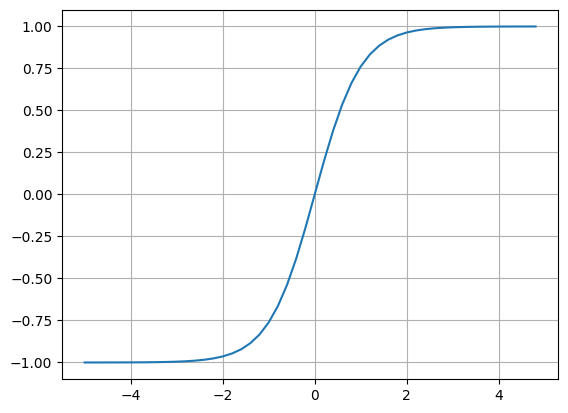

In [14]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid(True)

In [39]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

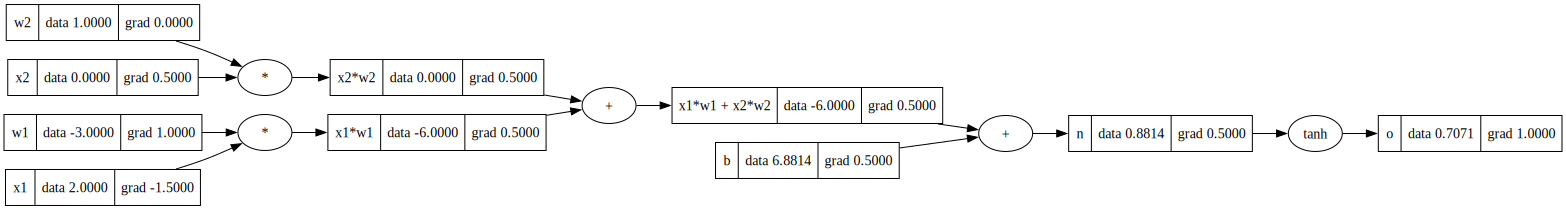

In [35]:
draw_dot(o)

In [30]:
o.grad = 1.0

In [31]:
o._backward()

In [33]:
n._backward()
x1w1x2w2._backward()

In [34]:
x1w1._backward()
x2w2._backward()

In [36]:
topo = []
visited = set()
def topological_sort(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            topological_sort(child)
        topo.append(v)
topological_sort(o)
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [37]:
o.backward()

In [63]:
# Make sure to run the cell where Value is defined (cell index: 7) before running this cell.
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (n * Value(2)).exp()
o = (e - Value(1)) / (e - Value(1))
o.label = 'o'

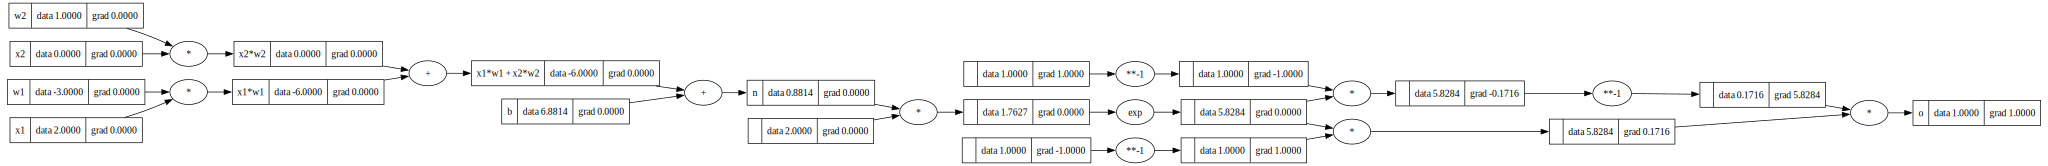

In [64]:
o.backward()
draw_dot(o)
